In [8]:
%matplotlib inline

import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# ACALIB helper functions
from acalib import load_fits, standarize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# `Orion.cont.image.fits`

In [10]:
fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


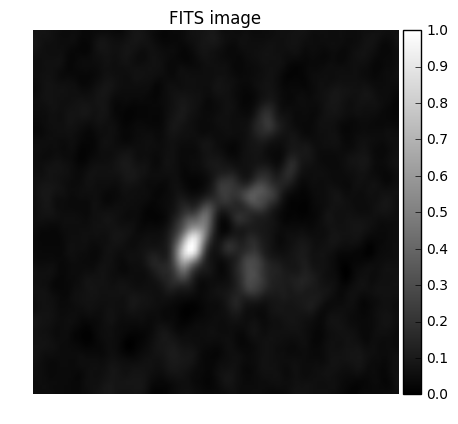

In [15]:
plt.figure(figsize=(5,5))
im = plt.imshow(data, cmap=plt.cm.gray)
plt.title('FITS image')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

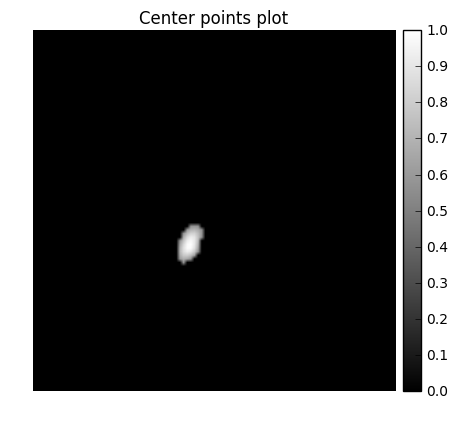

<function __main__.level_set_plot>

In [25]:
def level_set_plot(data, level):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    _data = np.zeros(data.shape)
    mask = data > level
    _data[mask] = data[mask]
    im = ax.imshow(_data, cmap=plt.cm.gray)
    plt.title('Center points plot')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(im, cax=cax)
    plt.show()

base_level = estimate_rms(data)
interact(level_set_plot, data=fixed(data), level=(base_level, 1.))

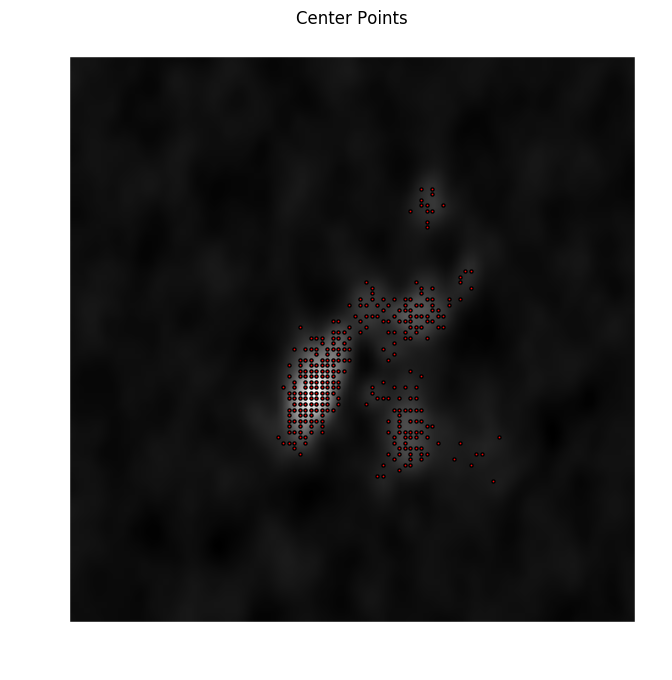

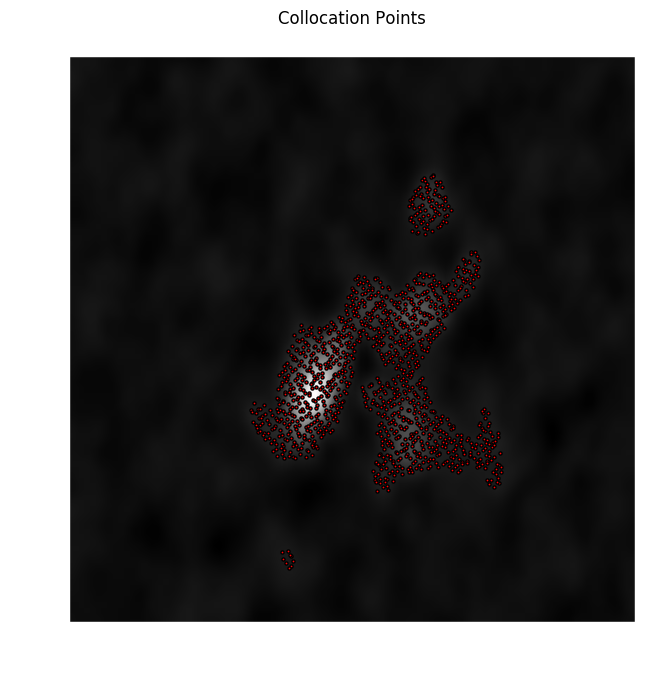

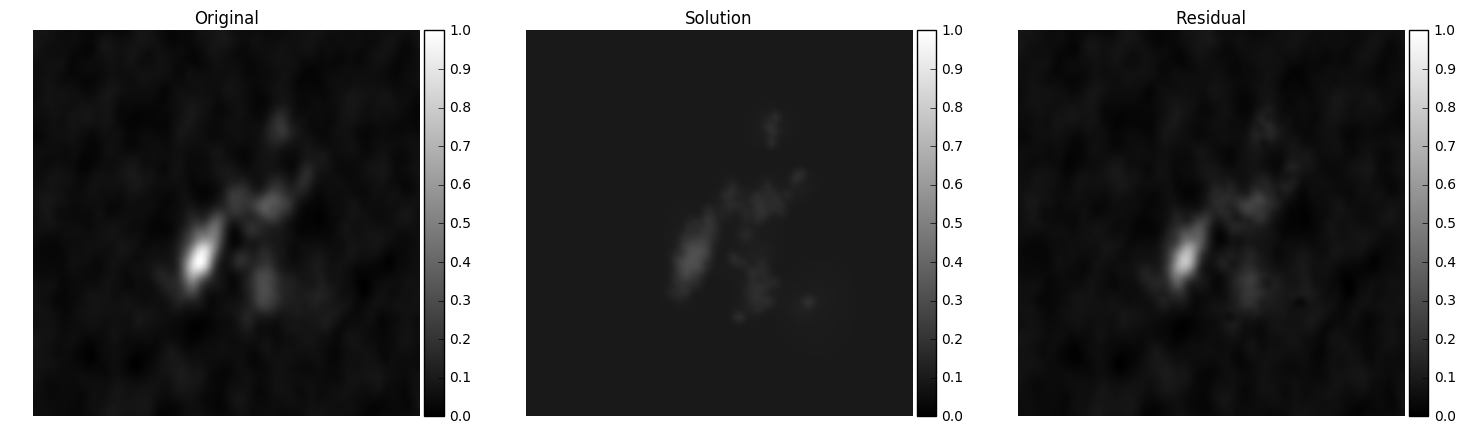

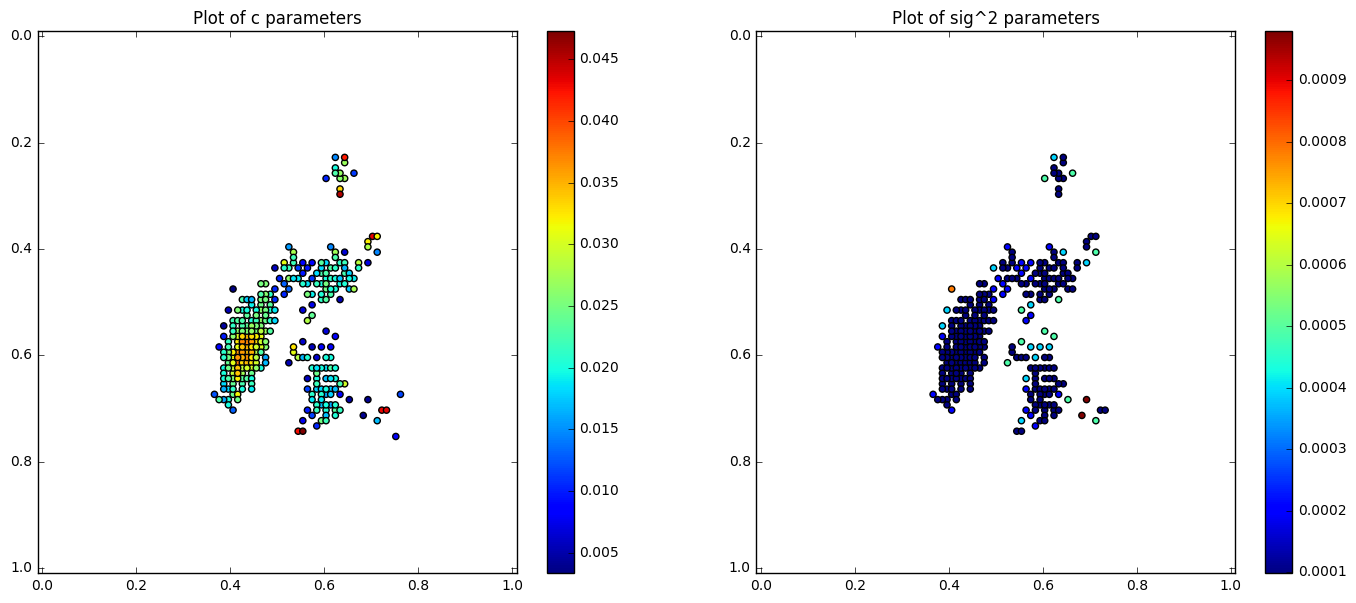

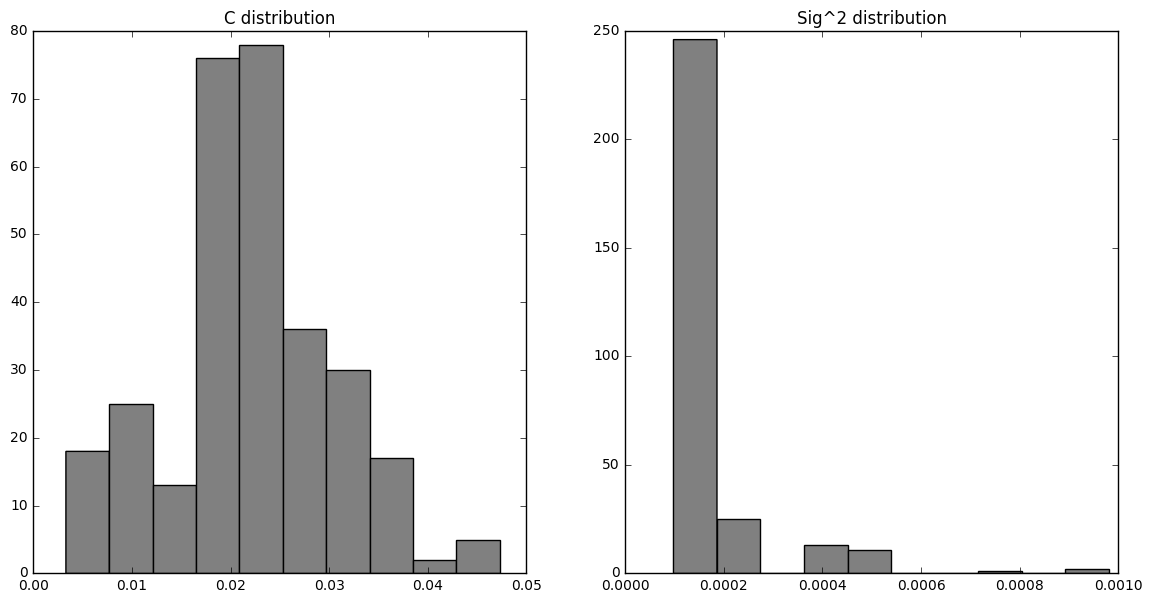

In [20]:
##########################################
# Approach 1
##########################################

# number of points of each type
Nb = 0
Nc = 300
Ne = 4*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=7.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

elm02 = copy.deepcopy(elm01)

../lib/utils.py:138: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))



 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:

success: False

status: 5

message: Number of calls to function has reached maxfev = 100000.

nfev: 100893
Residual RMS: 0.101088173711
Residual Variance: 2.04869962549e-05
Residual Entropy: 7.10576553425
Total elapsed time: 334.814049959 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.21215927714
Mean min distance between collocation and center points: 0.0116998139091


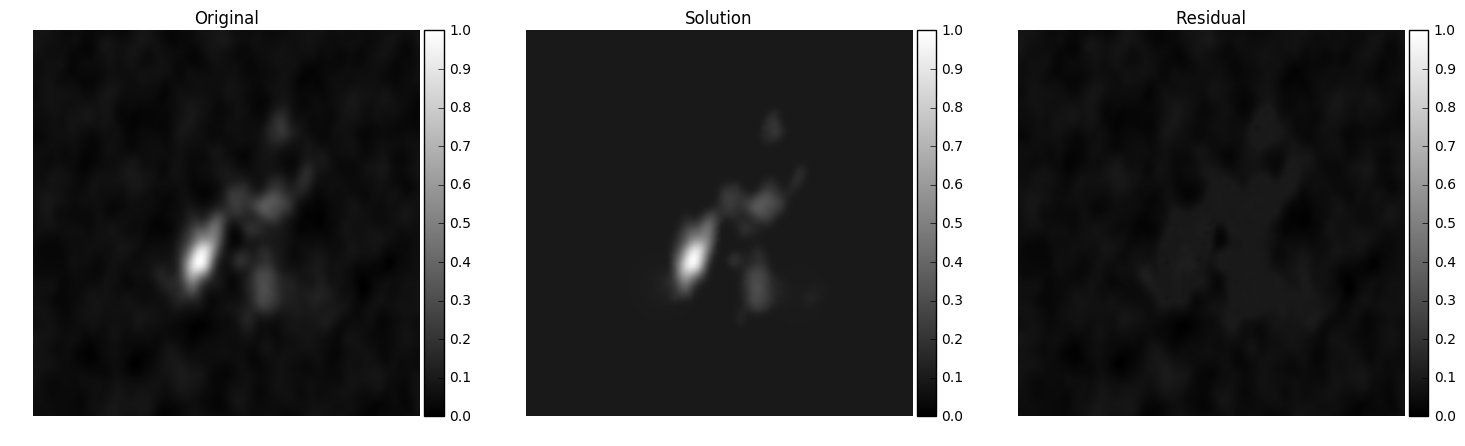

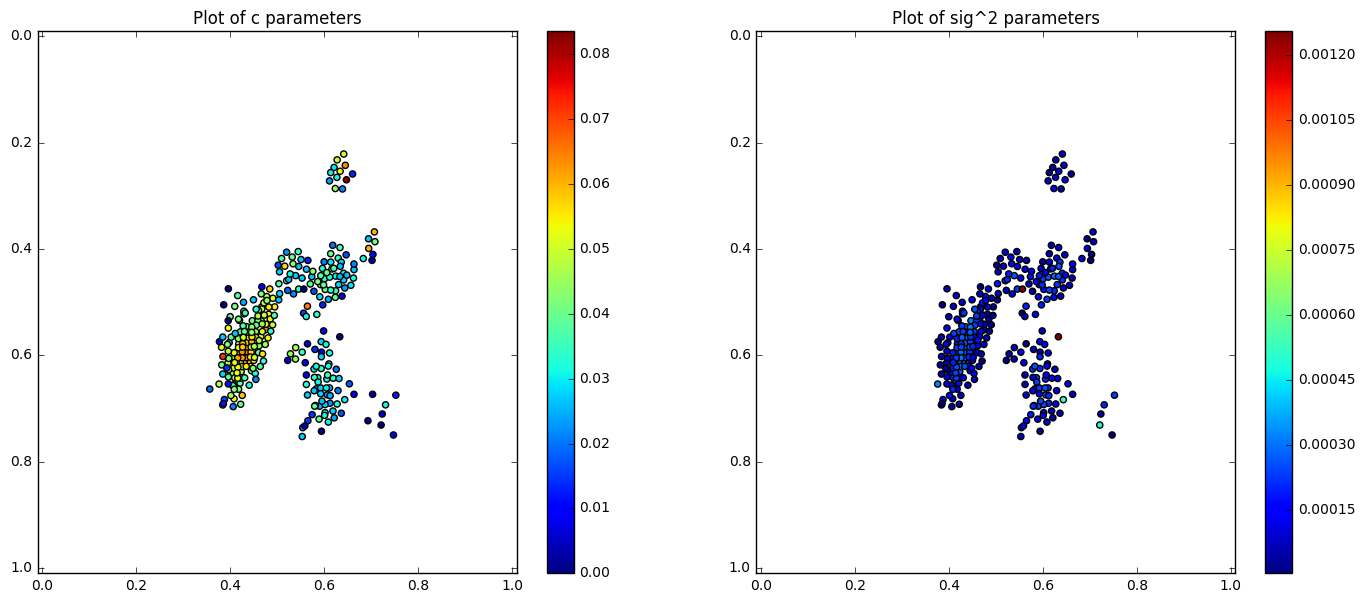

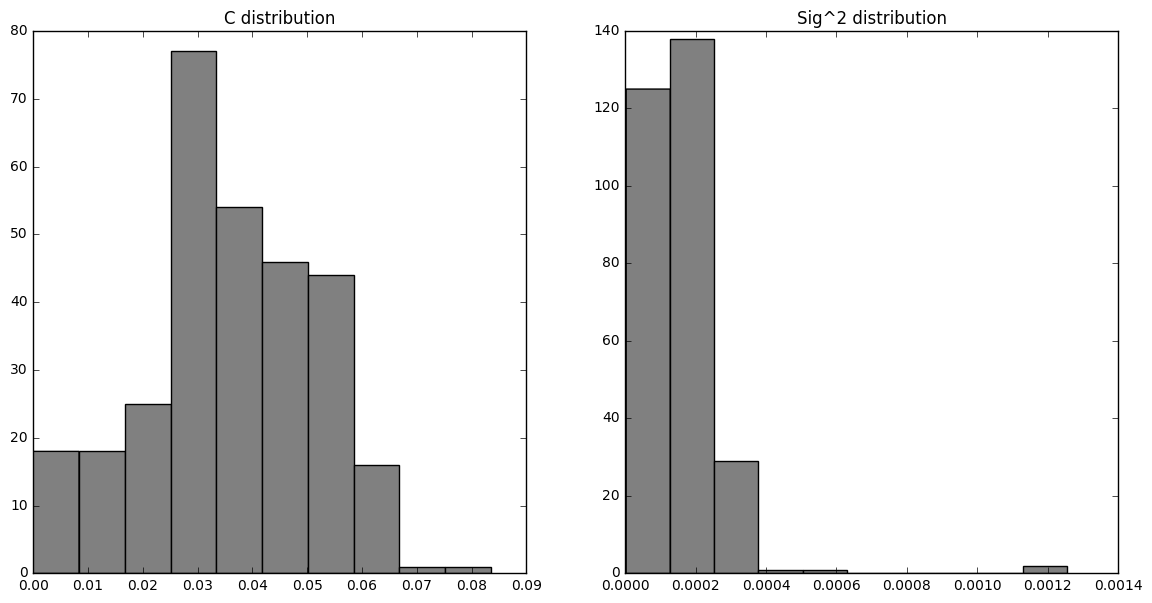

In [22]:
elm_solver(elm01, method='standard', max_nfev=100000)

In [23]:
# gaussian agglomeration
xc, yc, c, sig = elm01.get_params_mapped()
mu = np.vstack([xc, yc]).T

components_dict01 = gaussian_reduction(c, mu, sig, n_comp=1)

Merged components 189 and 202 with 2.89641175893e-13 dissimilarity
Merged components 207 and 292 with 2.08700537791e-12 dissimilarity
Merged components 294 and 295 with 1.19701614072e-10 dissimilarity
Merged components 262 and 285 with 6.75870801163e-08 dissimilarity
Merged components 109 and 184 with 0.000263582777514 dissimilarity
Merged components 291 and 292 with 0.000392856361715 dissimilarity
Merged components 205 and 267 with 0.000443488087873 dissimilarity
Merged components 48 and 192 with 0.000686332367355 dissimilarity
Merged components 34 and 170 with 0.000954201831813 dissimilarity
Merged components 71 and 159 with 0.000954399384323 dissimilarity
Merged components 177 and 210 with 0.00103156504295 dissimilarity
Merged components 27 and 160 with 0.00111467255448 dissimilarity
Merged components 90 and 108 with 0.00115069839961 dissimilarity
Merged components 16 and 54 with 0.00115405007699 dissimilarity
Merged components 142 and 259 with 0.0011989739253 dissimilarity
Merged c

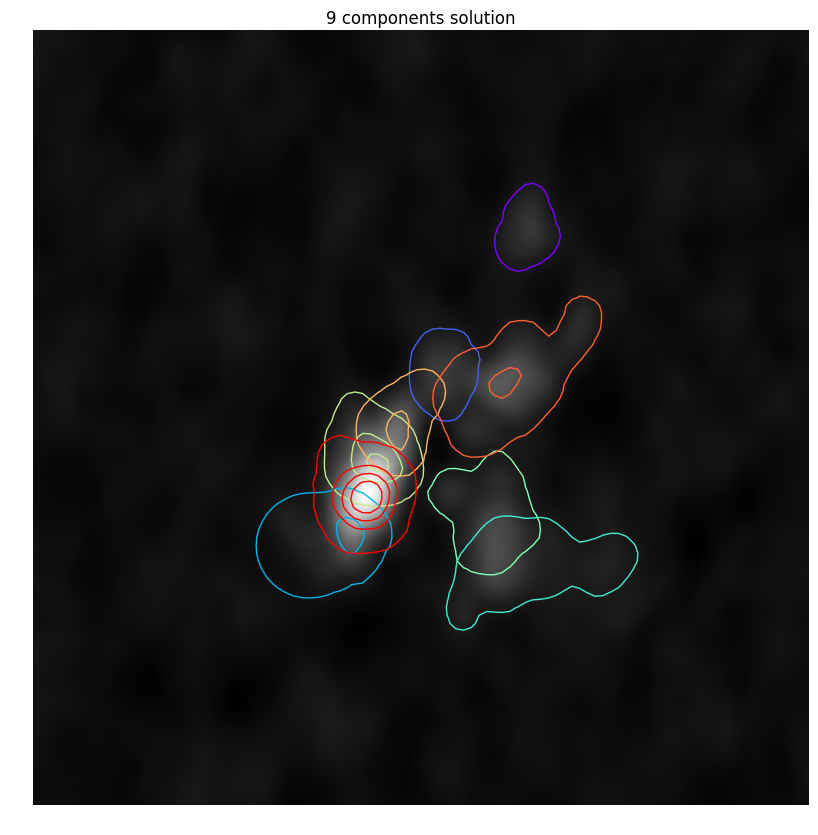

In [24]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

# `M100_combine_CO_cube.image.mom0.pbcor`

In [52]:
fits_path = '../data/images/M100_combine_CO_cube.image.mom0.pbcor.fits'
x, y, data, dfunc = load_data(fits_path)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


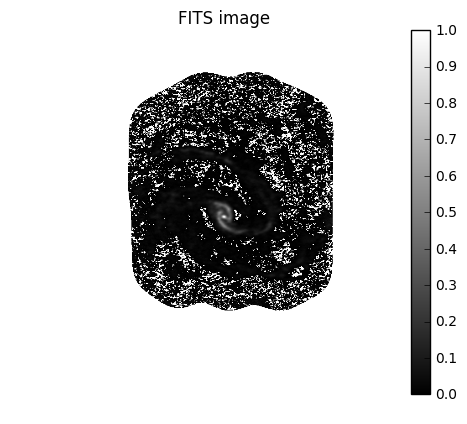

In [53]:
plt.figure(figsize=(5,5))
im = plt.imshow(data, cmap=plt.cm.gray)
plt.title('FITS image')
plt.axis('off')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

/home/mavillan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


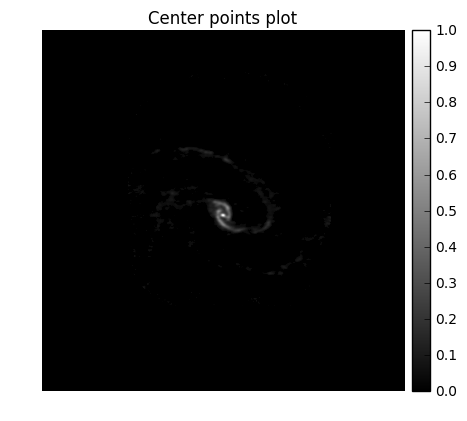

In [54]:
def level_set_plot(data, level):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    _data = np.zeros(data.shape)
    mask = data > level
    _data[mask] = data[mask]
    im = ax.imshow(_data, cmap=plt.cm.gray)
    plt.title('Center points plot')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.08)
    plt.colorbar(im, cax=cax)
    plt.show()
    
base_level = estimate_rms(data)
interact(level_set_plot, data=fixed(data), level=(base_level, 1.))

In [70]:
np.logical_or( data < base_level, data.mask )

/home/mavillan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [65]:
np.logical_or(data < base_level, data.mask) 

/home/mavillan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [57]:
##########################################
# Approach 1
##########################################

# number of points of each type
Nb = 0
Nc = 100
Ne = 4*Nc-4*Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=7.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)

elm02 = copy.deepcopy(elm01)

ValueError: probabilities do not sum to 1